# NIRCam PSF-matched multiband photometry

This is part of a [series of notebooks](https://github.com/dancoe/mirage) simulating and analyzing upcoming JWST NIRCam images in 7 filters: F115W F150W F200W F277W F356W F444W F480M. 

* HST catalog & Sersic fits – (Astropy.photutils, Astropy.modeling)
* NIRCam predicted fluxes in each filter – (BAGPIPES)
* NIRCam simulated image – (MIRAGE)
* Images processed & combined – (JWST Pipeline; CEERS tips & scripts)
* **Object Detections – (Astropy.photutils) (this notebook)**
* PSF-matched photometry – (Astropy.photutils)
* Photometry results inspection (this notebook)
* Photometric redshifts & SED fitting – (BAGPIPES)

These tools are meant for general use analyzing galaxies observed with JWST NIRCam. Here we've simulated observations upcoming in JWST GO 1433 (PI Coe) of the galaxy cluster MACS0647+70 and the triply-lensed z=11 candidate MACS0647-JD.

**NOTES:** 
* This is a work in progress. More accurate photometry may be obtainable.

* All images are aligned to the same 0.04" pixel grid prior to analysis. This alignment can be done using [`reproject`](https://reproject.readthedocs.io), if needed.

The simulated images *_i2d.fits are available here:
https://stsci.app.box.com/v/coe-nircam-mirage/folder/161595382965  
Unfortunately, there are currently slight misalignments between the short (< 2.4µm) and long (> 2.4 µm) wavelength images.

This simulation of a galaxy cluster is meant to complement existing simulations of blank fields:
* JADES: https://fenrir.as.arizona.edu/jaguar/
* CEERS: https://ceers.github.io/releases.html

An older version of this notebook (analyzing JADES simulated data) is available in STScI's JWST Data Analysis Tools (JDAT):  
https://spacetelescope.github.io/jdat_notebooks/notebooks/NIRCam_PSF-matched_photometry/NIRCam_PSF_matched_multiband_photometry.html

https://github.com/dancoe/mirage  
https://dancoe.space/jwst/simulations

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")

import astropy  # version 4.2 is required to write magnitudes to ecsv file
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

import photutils
print('photutils', photutils.__version__)
from photutils import Background2D, MedianBackground, detect_sources, deblend_sources, SourceCatalog#, source_properties
from photutils.utils import calc_total_error

from photutils.psf.matching import resize_psf
#from photutils import CosineBellWindow, create_matching_kernel
from astropy.convolution import convolve, convolve_fft # , Gaussian2DKernel, Tophat2DKernel

photutils 1.4.0


In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Show versions of Python and imported libraries
try:
    import watermark
    %load_ext watermark
    # %watermark -n -v -m -g -iv
    %watermark -iv -v
except ImportError:
    pass

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.0.1

matplotlib: 3.5.1
numpy     : 1.22.4
watermark : 2.3.1
astropy   : 5.0.4
photutils : 1.4.0



## Create list of images to be loaded and analyzed

All data and weight images must be aligned to the same pixel grid. 
(If needed, use [`reproject`](https://reproject.readthedocs.io) to do so.)

_i2d.fits extensions: [1] SCI, [2] ERR, [3] CONtext, [4] WHT, [5] VAR_POISSON, [6] VAR_RNOISE, [7] VAR_FLAT  
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html#resampled-2-d-data-i2d-and-s2d

1. SCI: 2-D data array containing the pixel values, in units of surface brightness  
2. ERR: 2-D data array containing resampled uncertainty estimates, given as standard deviation  
3. CON: 2-D context image, which encodes information about which input images contribute to a specific output pixel  
4. WHT: 2-D weight image giving the relative weight of the output pixels  
5. VAR_POISSON: 2-D resampled Poisson variance estimates for each pixel  
6. VAR_RNOISE: 2-D resampled read noise variance estimates for each pixel  
7. VAR_FLAT: 2-D resampled flat-field variance estimates for each pixel  

In [4]:
# _i2d.fits extensions: [1] SCI, [2] ERR, [3] CONtext, [4] WHT, [5] VAR_POISSON, [6] VAR_RNOISE, [7] VAR_FLAT

image_files_list = glob('images/*_i2d.fits')
image_files_list = list(np.sort(image_files_list))
filters = [image_file.split('_')[1] for image_file in image_files_list]
image_files = {}
wavelengths = np.array([int(filt[1:4]) / 100 for filt in filters]) * u.um  # e.g., F115W = 1.15 microns
for i, filt in enumerate(filters):
    image_files[filt] = image_files_list[i]

filters

['F115W', 'F150W', 'F200W', 'F277W', 'F356W', 'F444W', 'F480M']

## Load detection image: F200W

In [5]:
detection_filter = filt = 'F200W'
infile = image_files[filt]
hdu = fits.open(infile)
data = hdu[1].data
imwcs = wcs.WCS(hdu[1].header, hdu)

weight = hdu[4].data

## Report image size and field of view

In [6]:
ny, nx = data.shape
# image_pixel_scale = np.abs(hdu[0].header['CD1_1']) * 3600
image_pixel_scale = wcs.utils.proj_plane_pixel_scales(imwcs)[0] 
image_pixel_scale *= imwcs.wcs.cunit[0].to('arcsec')
outline = '%d x %d pixels' % (ny, nx)
outline += ' = %g" x %g"' % (ny * image_pixel_scale, nx * image_pixel_scale)
outline += ' (%.2f" / pixel)' % image_pixel_scale
print(outline)

3473 x 3497 pixels = 138.92" x 139.88" (0.04" / pixel)


<IPython.core.display.Javascript object>


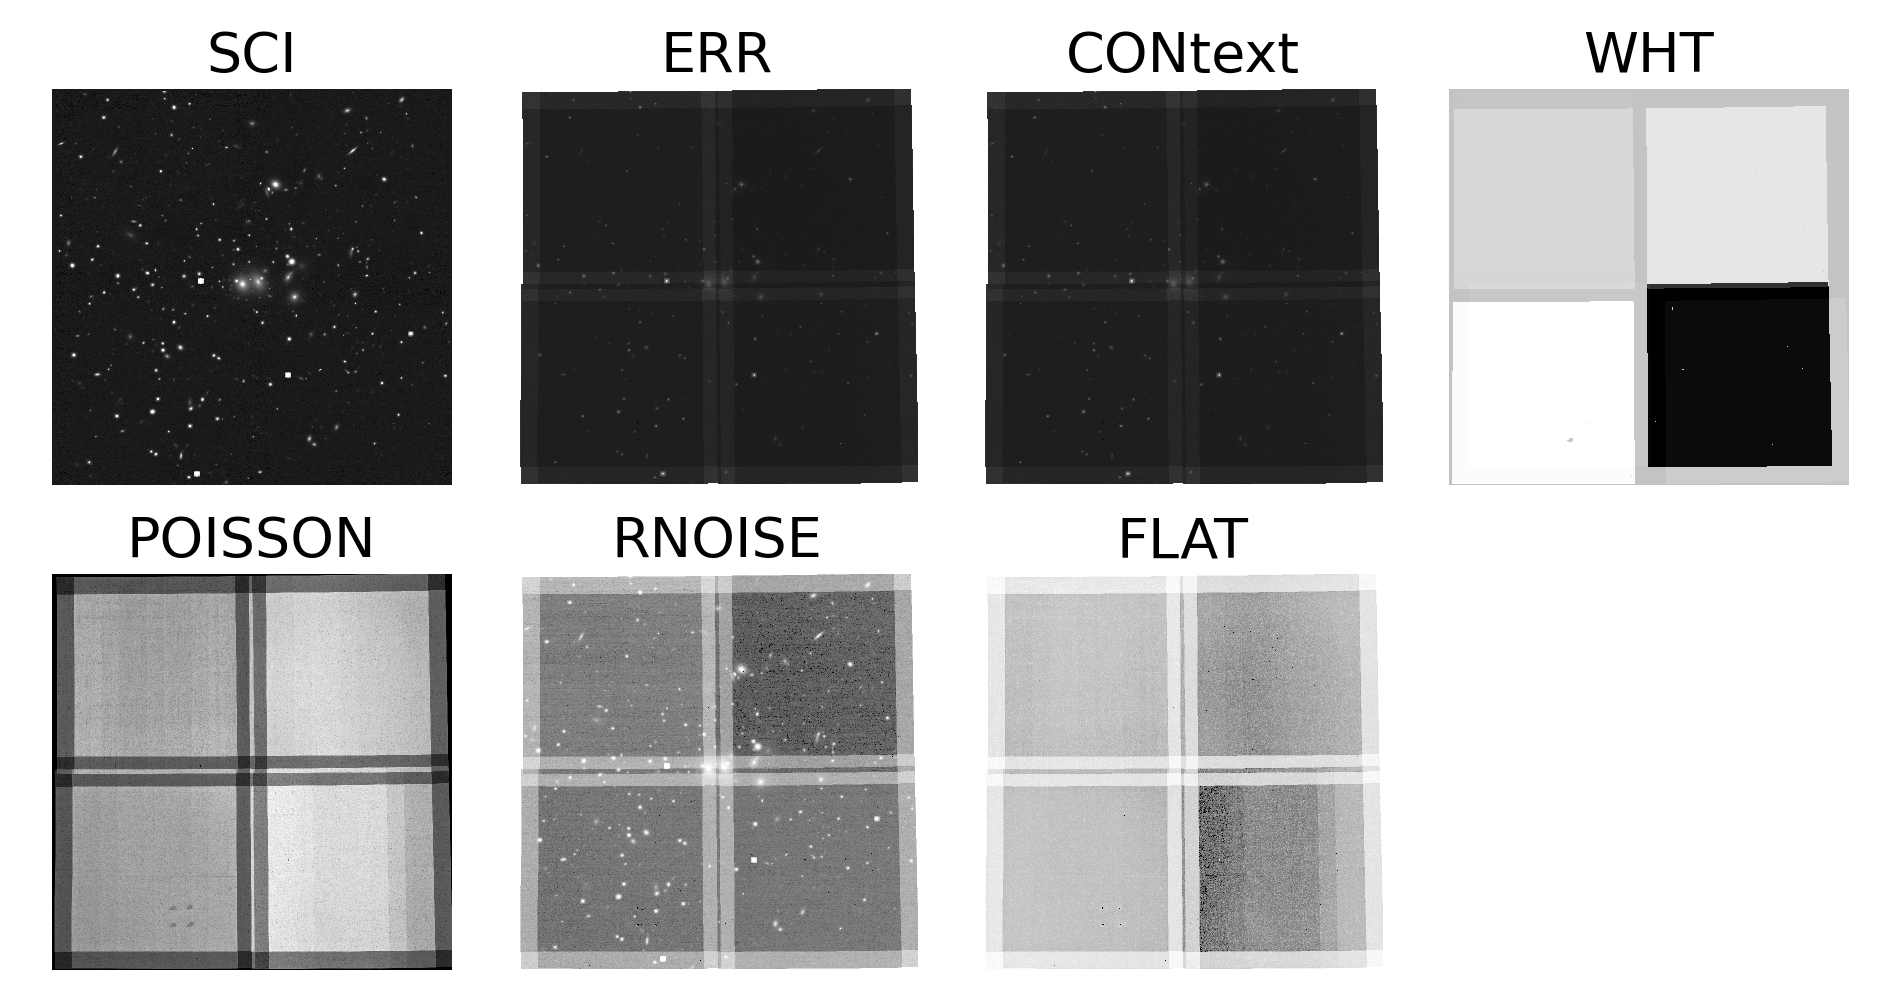

In [7]:
# Show image extensions
extensions = 'SCI ERR CONtext WHT POISSON RNOISE FLAT'.split()

fig, ax = plt.subplots(2, 4, figsize=(9.5,5), sharex=True, sharey=True)

norm = simple_norm(hdu[1].data, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[0,0].imshow(hdu[1].data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
#ax[0,0].imshow(hdu[1].data, origin='lower', interpolation='none', vmin=0, vmax=0.5, cmap='Greys_r' )
ax[0,0].set_title('SCI')

norm = ImageNormalize(stretch=LogStretch())
ax[0,1].imshow(hdu[2].data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
ax[0,1].set_title('ERR')

ax[0,2].imshow(hdu[2].data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
ax[0,2].set_title('CONtext')

ax[0,3].imshow(hdu[3].data, origin='lower', interpolation='none', cmap='Greys_r' )
ax[0,3].set_title('WHT')

ax[1,0].imshow(hdu[4].data, origin='lower', interpolation='none', cmap='Greys_r' )
ax[1,0].set_title('POISSON')

norm = simple_norm(hdu[5].data, 'log', min_percent=0.1, max_percent=99.9)
ax[1,1].imshow(hdu[5].data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
ax[1,1].set_title('RNOISE')

norm = simple_norm(hdu[6].data, 'log', min_percent=0.1, max_percent=99.9)
ax[1,2].imshow(hdu[6].data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
ax[1,2].set_title('FLAT')

for iy in range(2):
    for ix in range(4):
        ax[iy,ix].axis('off')

#norm = ImageNormalize(stretch=LogStretch())  # scale each filter individually
#norm = ImageNormalize(stretch=SqrtStretch())
#ax[i].imshow(hdu[i+1].data, cmap='Greys_r', norm=norm, origin='lower')
#ax[i].set_title(extensions[i])
#ax[i].axis('off')

## Detect Sources and Deblend using astropy.photutils
https://photutils.readthedocs.io/en/latest/segmentation.html

In [8]:
filt = 'F200W'
image_file = image_files[filt]
hdu = fits.open(image_file)
data = hdu[1].data  # 'SCI' extension 1
data_error = hdu[2].data  # 'ERR' extension 1
# total error array (i.e., the background-only error plus Poisson noise due to individual sources)
# https://photutils.readthedocs.io/en/stable/segmentation.html#photometric-errors

# Background Estimation
# https://photutils.readthedocs.io/en/stable/background.html
background_map = Background2D(data, 50, filter_size=3)  # 50 = cell size (width = height)

# Detect Sources
nsigma  = 3
npixels = 5
detection_threshold = (nsigma * background_map.background_rms) + background_map.background

# Before detection, convolve data with Gaussian
smooth_fwhm = 2
kernel_size = 5
smooth_sigma = smooth_fwhm * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(smooth_sigma, x_size=kernel_size, y_size=kernel_size)
convolved_data = convolve(data, kernel, normalize_kernel=True)

In [9]:
# Detect sources with npixels connected pixels at/above threshold in data smoothed by kernel
# https://photutils.readthedocs.io/en/stable/segmentation.html
segm_detect = detect_sources(convolved_data, detection_threshold, npixels=npixels, kernel=kernel)

In [10]:
# Deblend: separate connected/overlapping sources
# https://photutils.readthedocs.io/en/stable/segmentation.html#source-deblending
segm_deblend = deblend_sources(convolved_data, segm_detect, npixels=npixels, kernel=kernel, nlevels=32, contrast=0.001)

In [11]:
# Source Catalog: measure properties of detected objects
# https://photutils.readthedocs.io/en/stable/segmentation.html#centroids-photometry-and-morphological-properties
# error = total error array (i.e., the background-only error plus Poisson noise due to individual sources)
detection_catalog = SourceCatalog(data-background_map.background, segm_deblend, convolved_data=convolved_data,
                    wcs=imwcs, error=data_error, background=background_map.background, localbkg_width=24)

In [12]:
# Save segmentation map of detected objects
segm_hdu = fits.PrimaryHDU(segm_deblend.data.astype(np.uint32), header=imwcs.to_header())
field = 'MACS0647'
#segm_hdu.writeto(field+'_detections_segm.fits', overwrite=True)

## View / save measured quantities in detection image (optional)

### Only keep some quantities

In [13]:
# detection_catalog -> source_table

columns = 'label xcentroid ycentroid sky_centroid area semimajor_sigma semiminor_sigma'.split()
columns += 'ellipticity orientation gini'.split()
columns += 'kron_radius local_background segment_flux segment_fluxerr kron_flux kron_fluxerr'.split()
# columns += 'source_sum source_sum_err kron_flux kron_fluxerr kron_radius local_background'.split()

source_table = detection_catalog.to_table(columns=columns)
source_table.rename_column('label', 'id')
source_table.rename_column('semimajor_sigma', 'a')
source_table.rename_column('semiminor_sigma', 'b')

source_table.rename_column('xcentroid', 'x')
source_table.rename_column('ycentroid', 'y')

# Replace sky_centroid with ra, dec
source_table['ra']  = source_table['sky_centroid'].ra.degree  * u.degree
source_table['dec'] = source_table['sky_centroid'].dec.degree * u.degree

columns = list(source_table.columns)
columns = columns[:3] + ['ra', 'dec'] + columns[4:-2]

source_table = source_table[columns]

In [ ]:
# If interested, view / save output, but photometry in other filters will be added soon!
if 0:
    source_table.write(field+'_detections.ecsv', overwrite=True)
    source_table.write(field+'_detections.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
    source_table

<IPython.core.display.Javascript object>


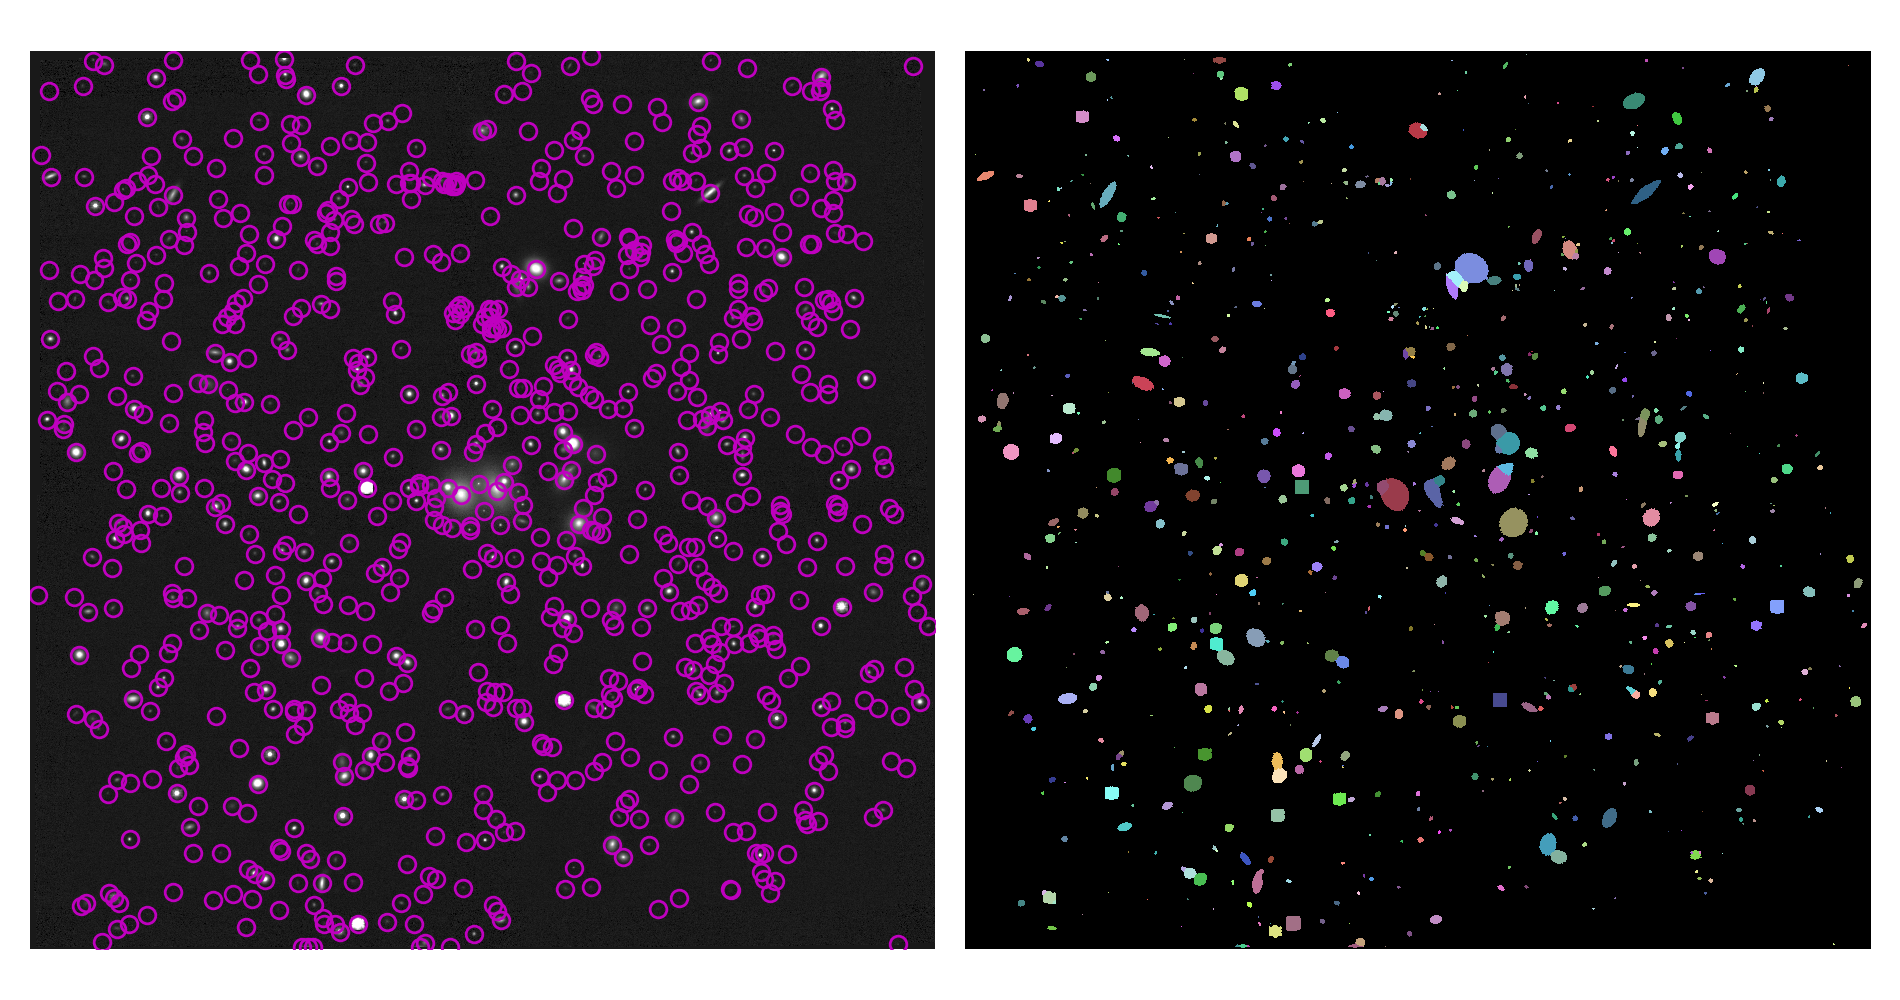

In [14]:
# Show detections segmentation map
fig, ax = plt.subplots(1, 2, figsize=(9.5,5), sharex=True, sharey=True)

norm = simple_norm(data, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[0].imshow(data, origin='lower', interpolation='none', norm=norm, cmap='Greys_r' )
ax[0].plot(source_table['x'], source_table['y'], 'mo', mfc='None')

cmap = segm_deblend.make_cmap(seed=123)
ax[1].imshow(segm_deblend, origin='lower', interpolation='none', cmap=cmap)

for ix in range(2):
    ax[ix].axis('off')

## Convert measured fluxes (data units) to magnitudes

https://docs.astropy.org/en/stable/units/

https://docs.astropy.org/en/stable/units/equivalencies.html#photometric-zero-point-equivalency

https://docs.astropy.org/en/stable/units/logarithmic_units.html#logarithmic-units

JWST data units: MJy / sr  
Mega Janskys (MJy); mag_AB = -2.5 log10(flux_Jy) + 8.90  
steradian (sr) is a unit of solid angle: 4 pi sr on a sphere  

In [15]:
JWST_flux_units = u.MJy / u.sr
image_flux_units = JWST_flux_units * (image_pixel_scale * u.arcsec)**2
zeropoint = image_flux_units.to(u.ABmag)
zeropoint # not needed here

<Magnitude 27.46182571 mag(AB)>

In [16]:
# not detected: mag =  99; magerr = 1-sigma upper limit assuming zero flux
# not observed: mag = -99; magerr = 0
def fluxes2mags(flux, fluxerr):
    nondet = flux < 0  # Non-detection if flux is negative
    unobs = (fluxerr <= 0) + (fluxerr == np.inf)  # Unobserved if flux uncertainty is negative or infinity

    mag = flux.to(u.ABmag)
    magupperlimit = fluxerr.to(u.ABmag) # 1-sigma upper limit if flux=0

    mag = np.where(nondet, 99 * u.ABmag, mag)
    mag = np.where(unobs, -99 * u.ABmag, mag)

    magerr = 2.5 * np.log10(1 + fluxerr/flux) 
    magerr = magerr.value * u.ABmag

    magerr = np.where(nondet, magupperlimit, magerr)
    magerr = np.where(unobs, 0 * u.ABmag, magerr)
    
    return mag, magerr

# Includes features I couldn't find in astropy:
# mag = 99 / -99 for non-detections / unobserved
# flux uncertainties -> mag uncertainties

In [17]:
flux    = source_table['segment_flux']    * image_flux_units
fluxerr = source_table['segment_fluxerr'] * image_flux_units

mag, magerr = fluxes2mags(flux, fluxerr)
source_table['segment_mag']    = mag
source_table['segment_magerr'] = magerr

In [18]:
flux    = source_table['kron_flux']    * image_flux_units
fluxerr = source_table['kron_fluxerr'] * image_flux_units

mag, magerr = fluxes2mags(flux, fluxerr)
source_table['kron_mag']  = mag
source_table['kron_magerr'] = magerr

In [ ]:
source_table.write(field+'_isophotal_photometry.ecsv', overwrite=True)
source_table.write(field+'_isophotal_photometry.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
source_table